# Molecule Classification

Here we are going to analyse images generated from a microscope that uses distance and matches to colour to create images.
We will be able to classify the different molecules in each individual image and colour over the image using different classification algorithms.


In [2]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# import the One vs One and One vs Rest classifiers
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier  
from sklearn.metrics import confusion_matrix # import the confusion matrix function
from sklearn.metrics import accuracy_score # import the score functions
import cv2
import matplotlib.image as mpimg
from copy import deepcopy

PENALTY = 10. # use mild Ridge regularization throughout

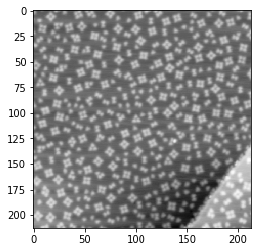

In [3]:
image = cv2.imread("Data_1All Images GREYSCALE BACKGROUND CORRECTTED_Helicene_Ag(111)021.png")#Helicene_Ag(111)008.png
image1 = cv2.imread("Data_1All Images_Helicene_Ag_111_008")


#image = cv2.imread("180509_18-16-48_SPM001.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap = "gray")

## Colour contours

We generate the image and display the contours

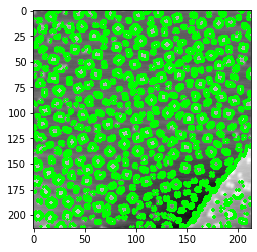

In [4]:
blur = gray
# blur = cv2.GaussianBlur(gray, (7,7), 0)
plt.imshow(blur, cmap = "gray")
canny = cv2.Canny(blur, 240,255,3)
plt.imshow(canny, cmap = "gray")
dilated = canny
# dilated = cv2.dilate(canny, (1,1), iterations = 3)
plt.imshow(dilated, cmap = "gray")
(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0,255,0), 2)
plt.imshow(rgb)
k = []
for i in range(len(cnt)):
    k.append(len(cnt[i]))
k
x_min = min(k)
x_max = max(k)
h=1
xx = np.meshgrid(np.arange(x_min, x_max, h))
new_data = {'freq': k}##note that K is the pixel count for each contour
count_df = df = pd.DataFrame(new_data)##produces the data frame
count_df["molecule_type"]=np.nan##adds in the NaN values that will be edited when the whole data frame is predicted
count_df = count_df.rename(columns={'pixel count': 'pixel_count'})
XX = count_df[count_df.columns[:1]]##contains the pixel count values for the contours for the whole image
YY = count_df[count_df.columns[-1]]##this is for the whole image predicted count, to be edited later

## Training data and algorithm

Here we had to manually label some data so we could train the algorithm to identify different contours.
We import it then use the logistic regression solver

In [5]:
df1 = pd.read_csv("edge_detection_training.csv")##test/train data set
df1 = df1.rename(columns={'Unnamed: 0': 'molecule_type'})
df1.drop(["molecule_type"], axis = 1, inplace = True)##drop the unnecessary column produced by the reading
X1 = df1[df1.columns[:1]]##gets the index and pixel count columns
Y1 = df1[df1.columns[1]]##gets the actual manual checks column, note it is already in a code form 0=1 atom 1=2 atom etc
categories = df1.Molecule_Name.unique()##gets the category array for later use
categories

array(['1_Atom', '2_Atoms', '4_Atoms', '3_Atoms'], dtype=object)

In [10]:
##HERE is the one vs rest classifier 
LR = LogisticRegression(solver='lbfgs',random_state=0,C=PENALTY)##initiating the  regression
clf_whole = OneVsRestClassifier(LR).fit(X1,Y1)##using one vs rest, by fitting the train variables
Y_pred_actual = clf_whole.predict(XX)
Y_pred_actual
##now we need to get this into the data frame, from the array form
for i in range(len(Y_pred_actual)):##here we are looping and putting the results of the prediction for whole image
   count_df.loc[i,"molecule_type"]=Y_pred_actual[i]
Y_pred_interp = clf_whole.predict(X1)

In [11]:
def plt_confusion_matrix(Y_test, y_pred, method):
    """
    Given actual target values and predicted values for a classifier 'method', 
    plots the confusion matrix
    """
    cnf_matrix = confusion_matrix(Y_test, y_pred) # create a confusion matrix for our actual and predicted values
    # write the confusion matrix to a dataframe with row and column names as the categories, which are already defined
    cmatrix = pd.DataFrame(cnf_matrix,columns=categories,index=categories) 
    f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits
    
    

Here is a visualization of the dataframe we will train on, it has the amount of pixels for each contour then the label predicted.

In [12]:
count_df

,freq,molecule_type
0,1,0.0
1,3,0.0
2,1,0.0
3,3,0.0
4,1,0.0
...,...,...
730,16,0.0
731,15,0.0
732,13,0.0
733,8,0.0


## One Vs One Classifier

The One vs One classifier attempts to generate the molecule type from the amount of pixels for each contour.

In [257]:
##consider the  real training and testing 
##here we try and do a one vs one predictor
one_one_count_df=count_df.copy(deep=True)##deep copy so that it works for all 
lencat=len(categories)
for molecule in categories: # loop over all the labels in categories
    # + concatenates two strings
    df1['molecule_'+molecule] = pd.Series(df1['Molecule_Name']==molecule).astype(int)
for (i,Molecule_Name) in zip(range(lencat), categories):
    # a new data frame with the selected molecule type dropped
    new_df1 = df1.drop(df1[df1.Molecule_Name == Molecule_Name].index)##this is updated each iteration of the loop
    X_ovo = new_df1[new_df1.columns[:1]] # take the first feature, updated each loop
    Y_ovo = new_df1['Molecule_Type'] # uses code for classification, since this is now binary
    # instantatiate the Logistic Regression model with the standard solver and random_state=0 to 
    # ensure the results are repeatable, and mild regularization using the parameter PENALTY defined earlier
    logreg2 = LogisticRegression(solver='lbfgs',random_state=0,C=PENALTY)
    logreg2.fit(X_ovo,Y_ovo) # fit the training data to the model
    coef2 = logreg2.coef_ # extract the coefficients of the model (maybe not required)

# create a target variable which is the integer column for the species
Y = df1.Molecule_Type

# instantatiate the Logistic Regression model with the standard solver and random_state=0 to 
LR2 = LogisticRegression(solver='lbfgs',random_state=0,C=PENALTY)
# use the one versus one classifier to fit the data
clf2 = OneVsOneClassifier(LR2).fit(X1,Y1)
Y_pred_one_one = clf2.predict(X1) # predict the results for the test feature values

The accuracy is generated below

In [59]:
lst=[]
##this just checks the accuracy when it is interpolation, not extraporlation
for i in range(len(Y_pred_one_one)):
    if Y1.iloc[i] == Y_pred_one_one[i]:
        lst.append(1)
    else:
        lst.append(0)
accuracy=sum(lst)/len(lst)
accuracy=accuracy*100
accuracy

70.83333333333334

## One vs All classifier

The difference between this and the one Vs One is it compares to all other contours each time, more computation but should be slightly more accurate.

In [75]:
#this is the prediction for the whole data set
Y_pred_one_vs_all_actual=clf2.predict(XX)
for i in range(len(Y_pred_actual)):
   one_one_count_df.loc[i,"molecule_type"]=Y_pred_one_vs_all_actual[i]

## Visualisation

The code to colour code the image with each contour being the colour predicted by the model, the One Vs One classifier Model.

### One Vs One

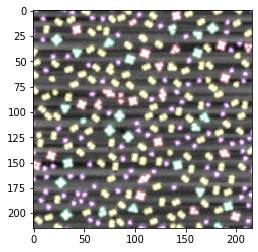

In [243]:
##overlay for the one vs one classifier
blur = gray
# blur = cv2.GaussianBlur(gray, (7,7), 0)

canny = cv2.Canny(blur, 240,255,3)

dilated = canny
# dilated = cv2.dilate(canny, (1,1), iterations = 3)

(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

for i in range(len(one_one_count_df)):
    if one_one_count_df.loc[i, "molecule_type"]==0:
        cv2.drawContours(rgb, cnt[i], -1, (143, 20, 219), 2)
    elif  one_one_count_df.loc[i, "molecule_type"]==1:
        cv2.drawContours(rgb, cnt[i], -1, (237, 230, 31), 2)
    elif one_one_count_df.loc[i, "molecule_type"]==2:
        cv2.drawContours(rgb, cnt[i], -1, (237, 43, 65), 2)
    elif one_one_count_df.loc[i, "molecule_type"]==3:
        cv2.drawContours(rgb, cnt[i], -1, (43, 237, 140), 2)
plt.imshow(rgb)

overlay  =cv2.addWeighted(rgb, 0.3, image, 1, 0)
plt.imshow(overlay)

    

In [9]:
count_df
blur = gray
# blur = cv2.GaussianBlur(gray, (7,7), 0)

canny = cv2.Canny(blur, 240,255,3)

dilated = canny
# dilated = cv2.dilate(canny, (1,1), iterations = 3)

(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

for i in range(len(one_one_count_df)):
    if one_one_count_df.loc[i, "molecule_type"]==0:
        cv2.drawContours(rgb, cnt[i], -1, (143, 20, 219), 2)
    elif  one_one_count_df.loc[i, "molecule_type"]==1:
        cv2.drawContours(rgb, cnt[i], -1, (237, 230, 31), 2)
    elif one_one_count_df.loc[i, "molecule_type"]==2:
        cv2.drawContours(rgb, cnt[i], -1, (237, 43, 65), 2)
    elif one_one_count_df.loc[i, "molecule_type"]==3:
        cv2.drawContours(rgb, cnt[i], -1, (43, 237, 140), 2)
plt.imshow(rgb)

,freq,molecule_type
0,7,0.0
1,13,0.0
2,2,0.0
3,8,0.0
4,5,0.0
...,...,...
285,7,0.0
286,22,3.0
287,12,0.0
288,11,0.0


 ### Visualisation One vs All

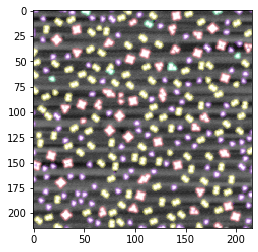

In [245]:
##this is the overlay for the one vs all classifier
count_df
blur = gray
# blur = cv2.GaussianBlur(gray, (7,7), 0)

canny = cv2.Canny(blur, 240,255,3)

dilated = canny
# dilated = cv2.dilate(canny, (1,1), iterations = 3)

(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)##just produces the image again
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

for i in range(len(one_one_count_df)):c##loop through all predicted values
    if count_df.loc[i, "molecule_type"]==0:##count_df is a data  frame with pixel counts and predicted type as columns
        cv2.drawContours(rgb, cnt[i], -1, (143, 20, 219), 2)##changes colour based on the result with if statements
    elif count_df.loc[i, "molecule_type"]==1:
        cv2.drawContours(rgb, cnt[i], -1, (237, 230, 31), 2)
    elif count_df.loc[i, "molecule_type"]==2:
        cv2.drawContours(rgb, cnt[i], -1, (237, 43, 65), 2)
    elif count_df.loc[i, "molecule_type"]==3:
        cv2.drawContours(rgb, cnt[i], -1, (43, 237, 140), 2)
plt.imshow(rgb)
overlay  =cv2.addWeighted(rgb, 0.3, image, 1, 0)##makes an overlay much easier on the eye
plt.imshow(overlay)

## Accuracy comparison

We can see a visualisation using a confusion matrix the accuracy of the one vs one and the one vs all, both
peformed poorly in defining the different between 4 atom and 3 atom classifiers. But well for 1 and 2 atom molecules.

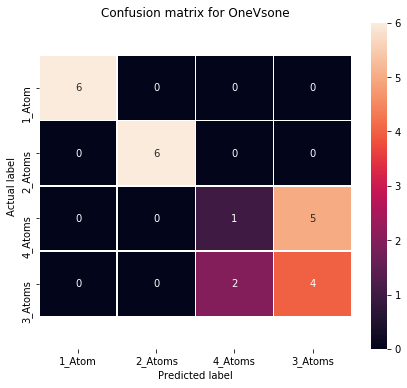

In [83]:
plt_confusion_matrix(Y1, Y_pred_one_one, 'OneVsone')

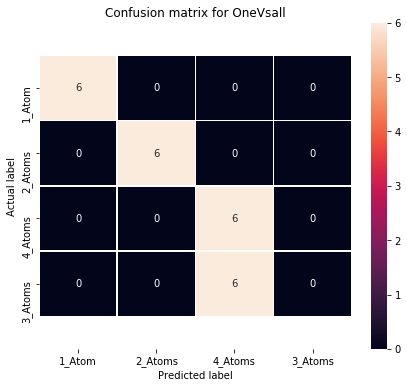

In [228]:
plt_confusion_matrix(Y1, Y_pred_interp, 'OneVsall')

## Applying the same model to a different image with the same molecules.
We can see it peforms well again but not for the larger molecules. It also finds errors in the finding of contours along
the anomly line at the bottom right that are clearly not proper contours.

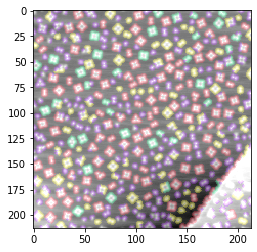

In [294]:
##overlay for the one vs one classifier
blur = gray
# blur = cv2.GaussianBlur(gray, (7,7), 0)

canny = cv2.Canny(blur, 240,255,3)

dilated = canny
# dilated = cv2.dilate(canny, (1,1), iterations = 3)

(cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

for i in range(len(count_df)):
    if count_df.loc[i, "molecule_type"]==0:
        cv2.drawContours(rgb, cnt[i], -1, (143, 20, 219), 2)
    elif  count_df.loc[i, "molecule_type"]==1:
        cv2.drawContours(rgb, cnt[i], -1, (237, 230, 31), 2)
    elif count_df.loc[i, "molecule_type"]==2:
        cv2.drawContours(rgb, cnt[i], -1, (237, 43, 65), 2)
    elif count_df.loc[i, "molecule_type"]==3:
        cv2.drawContours(rgb, cnt[i], -1, (43, 237, 140), 2)
plt.imshow(rgb)

overlay  =cv2.addWeighted(rgb, 0.3, image, 1, 0)
plt.imshow(overlay)